<a href="https://colab.research.google.com/github/lazybear-0425/EWC_Observation/blob/main/2025-03-23_20_15_26.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 - Life Lone Learning
 - Elastic Weight Consolidation (EWC)
    - [教學](https://www.kaggle.com/code/hughiephan/elastic-weight-consolidation-on-minst)
    - [Paper](https://arxiv.org/pdf/1612.00796)
    - 公式 $\mathcal{L}(\theta) = \mathcal{L}_B(\theta) + \frac\lambda2\sum^n_{i=1}F_i(\theta_i - \theta^*_{A,i})^2$
        - B是指目前任務，A是指前一個任務
 - [教學2](https://github.com/ContinualAI/colab/blob/master/notebooks/intro_to_continual_learning.ipynb)

In [31]:
import torch
from torch import nn
from torchvision.transforms import Compose, ToTensor, Normalize, RandomRotation, Lambda
import numpy as np
from torchvision.datasets import MNIST as FashionMNIST
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torch.nn import CrossEntropyLoss
from torch.optim import Adam, SGD
from torch.nn.functional import cross_entropy

In [32]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [33]:
batch_size = 256
epochs = 10
task = 2

 - [ToTensor](https://pytorch.org/vision/main/generated/torchvision.transforms.ToTensor.html)

In [34]:
def trans_compose(i=0):
    return Compose([
        # lambda x : np.rot90(x, i, axes=[0, 1]).copy(), # 使連續
        # lambda x: np.expand_dims(x, axis=-1),  # 因為ToTensor要PIL or ndarray(H x W x C)，之後轉成Tensor(C x H x W)
        ToTensor(),
        # Lambda(lambda x : x / 255.),
        RandomRotation((90 * i, 90 * i)),
        Normalize(mean=[0.0], std=[1])
    ])

In [35]:
# preprocessing
# train_task_1 = FashionMNIST('data', train=True, transform=trans_compose(0), download=True)
# train_task_2 = FashionMNIST('data', train=True, transform=trans_compose(1), download=True)

test_task_1 = FashionMNIST('data', train=False, transform=trans_compose(0), download=True)
test_task_2 = FashionMNIST('data', train=False, transform=trans_compose(1), download=True)

task_1_loader = DataLoader(test_task_1, batch_size=batch_size)
task_2_loader = DataLoader(test_task_2, batch_size=batch_size)

In [36]:
class Module(nn.Module):
    def __init__(self):
        super(Module, self).__init__()
        # self.classifier = nn.Sequential(
        #     nn.Conv2d(1, 10, kernel_size=5),
        #     nn.MaxPool2d(2),
        #     nn.ReLU(),
        #     nn.Conv2d(10, 20, kernel_size=5),
        #     nn.Dropout2d(),
        #     nn.MaxPool2d(2),
        #     nn.ReLU(),
        # )
        # self.dense = nn.Sequential(
        #     nn.Linear(320, 50),
        #     nn.ReLU(),
        #     nn.Dropout(),
        #     nn.Linear(50, 10)
        # )
        self.net = nn.Sequential(
            nn.Flatten(),
            nn.LazyLinear(10)
        )
    def forward(self, X):
        # return self.dense(self.classifier(X).view(-1, 320))
        return self.net(X)

In [37]:
def evaluate(model, dataloader, num_data, num_task=-1):
    if num_task < 0: raise ValueError("Task Number is Missing")

    test_acc = 0
    test_loss = 0
    with torch.no_grad():
        model.eval()
        for data in dataloader:
            img, label = data
            img, label = img.to(device), label.to(device).long()
            output = model(img)
            test_loss += cross_entropy(output, label)
            test_acc += (output.argmax(1) == label).sum()
    print('\033[33m' +
          f'Task {num_task} Acc: {test_acc / num_data: .4f}, Loss: {test_loss / num_data: .4f}' +
          '\033[0m')

In [38]:
def training_Setting(model):
    optimizer = Adam(model.parameters())
    loss = CrossEntropyLoss()
    return optimizer, loss

 - Fisher Matrix
     - 儲存權重對模型重要性
     - 計算方法
         - [LINK](https://github.com/db434/EWC)
             - 這個版本是**取樣** $\rightarrow$ 計算梯度
         - 這邊的範例程式碼是直接**整個資料**來計算梯度
         - 公式
             - $F_j = \frac1m \sum^m_{i=1}(\frac{\partial \log (P(x_i|\theta_j))}{\partial \theta_j})^2$

In [39]:
# EWC
optim_para = {}
fisher_matrix = {}
ewc_lambda = 10

def record_parameter(model, train_data, optimizer, num_task=-1):
    if num_task < 0: raise ValueError("Task Number is Missing")
    global optim_para, fisher_matrix, ewc_lambda
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    model.train()
    optimizer.zero_grad()

    fisher_matrix[num_task] = {}
    optim_para[num_task] = {}

    # Initialize Fisher Matrix
    for name, param in model.named_parameters():
        fisher_matrix[num_task][name] = torch.zeros_like(param.data)

    # Calculate Fisher Matrix
    for data in train_loader:
        img, label = data
        img, label = img.to(device), label.to(device).long()
        output = model(img)
        output_loss = cross_entropy(output, label)
        output_loss.backward()

        for name, param in model.named_parameters():
            if param.grad is not None:
                fisher_matrix[num_task][name] += param.grad.data.clone().pow(2)

    # Average Fisher Matrix
    for name, param in model.named_parameters():
        fisher_matrix[num_task][name] /= len(train_loader)

    # Save optimal parameters
    for name, param in model.named_parameters():
        optim_para[num_task][name] = param.data.clone()

In [40]:
def training(model, test_loader : list, test_num : list, epochs = 10,  num_task=-1):
    if num_task < 0: raise ValueError("Task Number is Missing")
    global optim_para, fisher_matrix, ewc_lambda
    print(f'Task {num_task} Start!')

    train_data = FashionMNIST('data', train=True, transform=trans_compose(num_task), download=True)
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    # plt.imshow(train_data[0][0].reshape(28, 28), cmap='gray')
    # plt.title('Task' + str(num_task))
    # plt.show()

    # optimizer, loss = training_Setting(model)
    optimizer = Adam(model.parameters())

    for i in range(epochs):
        model.train()
        train_acc = 0
        train_loss = 0
        for data in train_loader:
            optimizer.zero_grad()

            img, label = data
            img, label = img.to(device), label.to(device).long()
            output = model(img)
            output_loss = cross_entropy(output, label)
            # Record
            train_acc += (output.argmax(1) == label).sum()
            # BP
            ewc_loss = 0
            for t in range(num_task):
                for name, param in model.named_parameters():
                    if t in optim_para:
                        fisher = fisher_matrix[t][name]
                        optim = optim_para[t][name]
                        if fisher.requires_grad == True or optim.requires_grad == True:
                            raise NotImplementedError('Frozen it!')
                        # output_loss += ewc_lambda * (fisher * (optim - param).pow(2)).sum() # .detach()
                        ewc_loss += (fisher * (optim - param).pow(2)).sum() * ewc_lambda
            # if tmp != 0: print(tmp)
            output_loss += ewc_loss
            train_loss += output_loss.detach()
            output_loss.backward()
            optimizer.step()
        print(f'Epoch\t{i + 1}\tAcc: {train_acc / len(train_data): .4f}, Loss: {train_loss / len(train_data): .4f}')
    record_parameter(model, train_data, optimizer, num_task=num_task)
    # Evaluate Task 0 & 1
    task_id = 0
    for num_data, loader in zip(test_num, test_loader):
        evaluate(model, loader, num_data, task_id)
        task_id = task_id + 1
    print() # End of Training

 - nn.Module
    - named_pa​​rameters()
         - 給出網絡層的名字和參數的迭代器
    - parameters()
         - 參數的迭代器
    - [Reference](https://blog.csdn.net/qq_36530992/article/details/102729585)

In [41]:
model = Module().to(device)

for i in range(task):
    training(model, [task_1_loader, task_2_loader], [len(test_task_1), len(test_task_2)], num_task=i, epochs=epochs)

Task 0 Start!
Epoch	1	Acc:  0.8169, Loss:  0.0033
Epoch	2	Acc:  0.8908, Loss:  0.0017
Epoch	3	Acc:  0.9041, Loss:  0.0014
Epoch	4	Acc:  0.9101, Loss:  0.0013
Epoch	5	Acc:  0.9147, Loss:  0.0012
Epoch	6	Acc:  0.9171, Loss:  0.0012
Epoch	7	Acc:  0.9193, Loss:  0.0011
Epoch	8	Acc:  0.9209, Loss:  0.0011
Epoch	9	Acc:  0.9223, Loss:  0.0011
Epoch	10	Acc:  0.9243, Loss:  0.0011
Task 0 Acc:  0.9237, Loss:  0.0011
Task 1 Acc:  0.1359, Loss:  0.0265

Task 1 Start!
Epoch	1	Acc:  0.3184, Loss:  0.0134
Epoch	2	Acc:  0.5649, Loss:  0.0078
Epoch	3	Acc:  0.6260, Loss:  0.0067
Epoch	4	Acc:  0.6578, Loss:  0.0062
Epoch	5	Acc:  0.6735, Loss:  0.0060
Epoch	6	Acc:  0.6822, Loss:  0.0058
Epoch	7	Acc:  0.6894, Loss:  0.0057
Epoch	8	Acc:  0.6938, Loss:  0.0056
Epoch	9	Acc:  0.6972, Loss:  0.0055
Epoch	10	Acc:  0.6999, Loss:  0.0055
Task 0 Acc:  0.6682, Loss:  0.0043
Task 1 Acc:  0.7092, Loss:  0.0039



 - Task 0

Accuracy 0.6682
Classification Report
              precision    recall  f1-score   support

    0 - zero       0.77      0.54      0.64       980
     1 - one       0.96      0.75      0.84      1135
     2 - two       0.62      0.71      0.66      1032
   3 - three       0.80      0.72      0.75      1010
    4 - four       0.31      0.77      0.44       982
    5 - five       0.66      0.60      0.63       892
     6 - six       0.73      0.75      0.74       958
   7 - seven       0.95      0.75      0.84      1028
   8 - eight       0.82      0.44      0.57       974
    9 - nine       0.83      0.63      0.72      1009

    accuracy                           0.67     10000
   macro avg       0.74      0.67      0.68     10000
weighted avg       0.75      0.67      0.69     10000



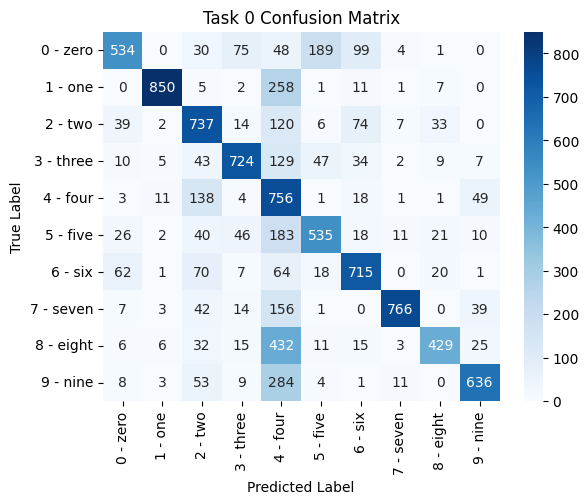

In [42]:
true_label = []
pred_label = []
with torch.no_grad():
    for data in task_1_loader:
        img, label = data
        img, label = img.to(device), label.to(device)
        output = model(img).argmax(1)
        true_label.extend(label.cpu().numpy())
        pred_label.extend(output.cpu().numpy())

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
print('\033[33m' + 'Accuracy' + '\033[0m', accuracy_score(true_label, pred_label))
print('\033[33m' + 'Classification Report' + '\033[0m',
      classification_report(true_label, pred_label, target_names=test_task_1.classes),
      sep='\n')
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(true_label, pred_label)
plt.cla(); plt.clf()
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=test_task_1.classes, yticklabels=test_task_1.classes)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Task 0 Confusion Matrix")
plt.show()

 - Task 1

Accuracy 0.7092
Classification Report
              precision    recall  f1-score   support

    0 - zero       0.92      0.94      0.93       980
     1 - one       0.87      0.93      0.90      1135
     2 - two       0.69      0.61      0.65      1032
   3 - three       0.58      0.58      0.58      1010
    4 - four       0.78      0.72      0.75       982
    5 - five       0.42      0.39      0.41       892
     6 - six       0.85      0.88      0.87       958
   7 - seven       0.76      0.77      0.77      1028
   8 - eight       0.50      0.53      0.52       974
    9 - nine       0.64      0.68      0.66      1009

    accuracy                           0.71     10000
   macro avg       0.70      0.70      0.70     10000
weighted avg       0.71      0.71      0.71     10000



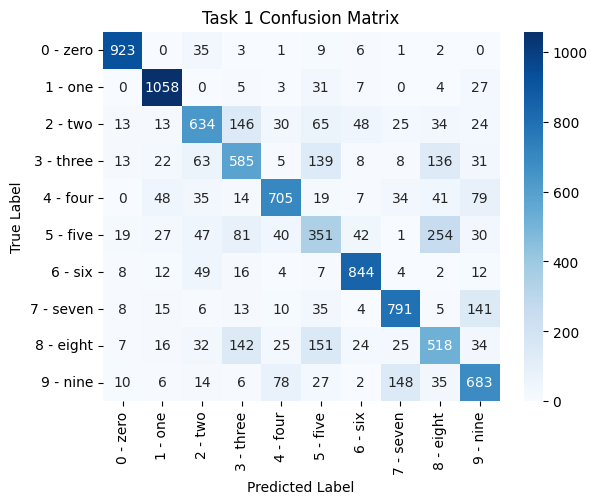

In [43]:
true_label = []
pred_label = []
with torch.no_grad():
    for data in task_2_loader:
        img, label = data
        img, label = img.to(device), label.to(device)
        output = model(img).argmax(1)
        true_label.extend(label.cpu().numpy())
        pred_label.extend(output.cpu().numpy())

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
print('\033[33m' + 'Accuracy' + '\033[0m', accuracy_score(true_label, pred_label))
print('\033[33m' + 'Classification Report' + '\033[0m',
      classification_report(true_label, pred_label, target_names=test_task_2.classes),
      sep='\n')
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(true_label, pred_label)
plt.cla(); plt.clf()
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=test_task_2.classes, yticklabels=test_task_2.classes)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Task 1 Confusion Matrix")
plt.show()

net.1.weight
torch.Size([10, 784])
Max fisher is 0.00559 and it's parameter diff is 0.00875
Min Parameter diff is 0.75424 and it's fisher is 0.00000


<Figure size 640x480 with 0 Axes>

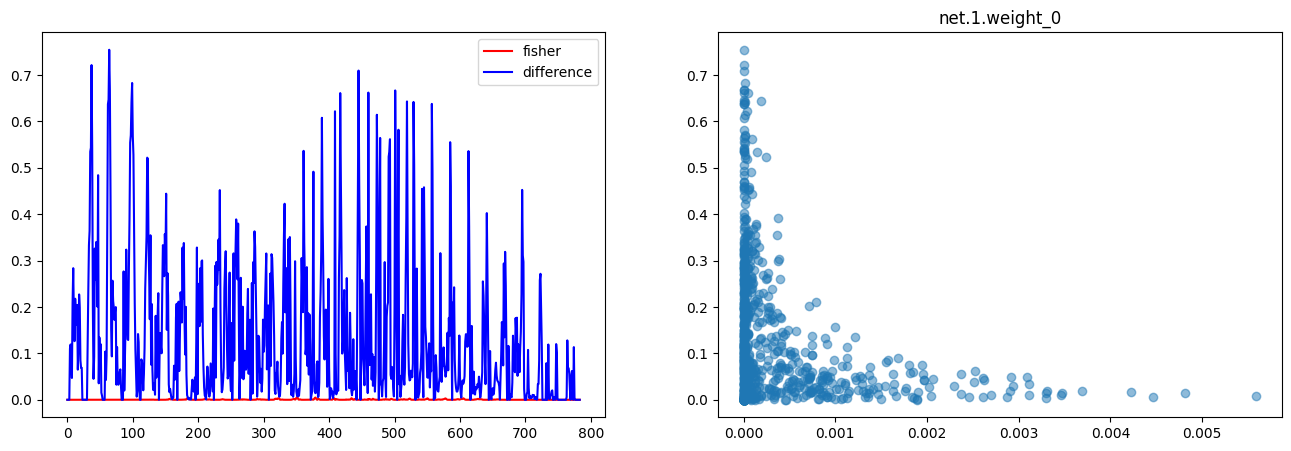

Max fisher is 0.04358 and it's parameter diff is 0.01020
Min Parameter diff is 1.04128 and it's fisher is 0.00000


<Figure size 640x480 with 0 Axes>

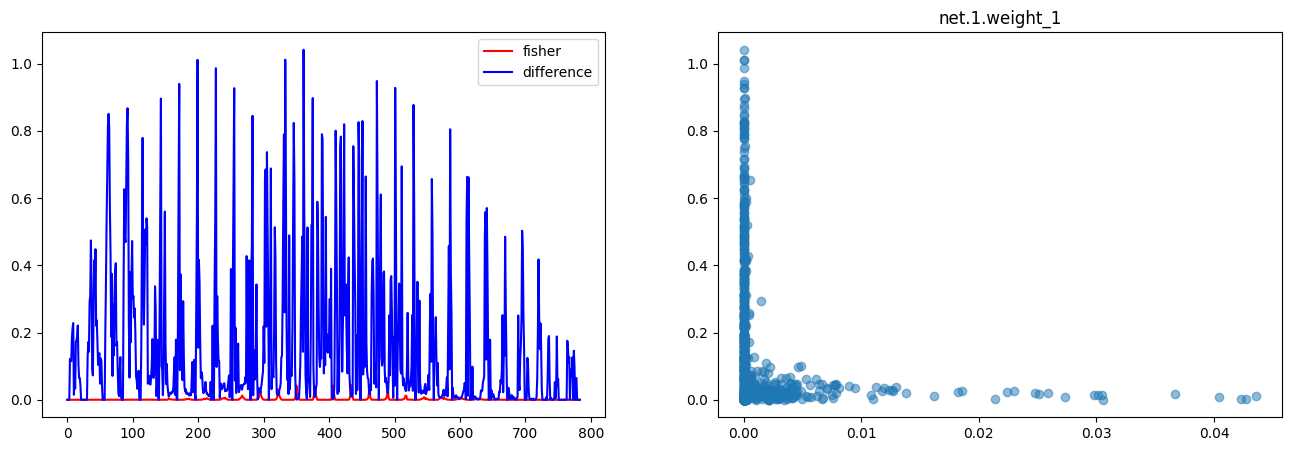

Max fisher is 0.02908 and it's parameter diff is 0.00374
Min Parameter diff is 0.97062 and it's fisher is 0.00000


<Figure size 640x480 with 0 Axes>

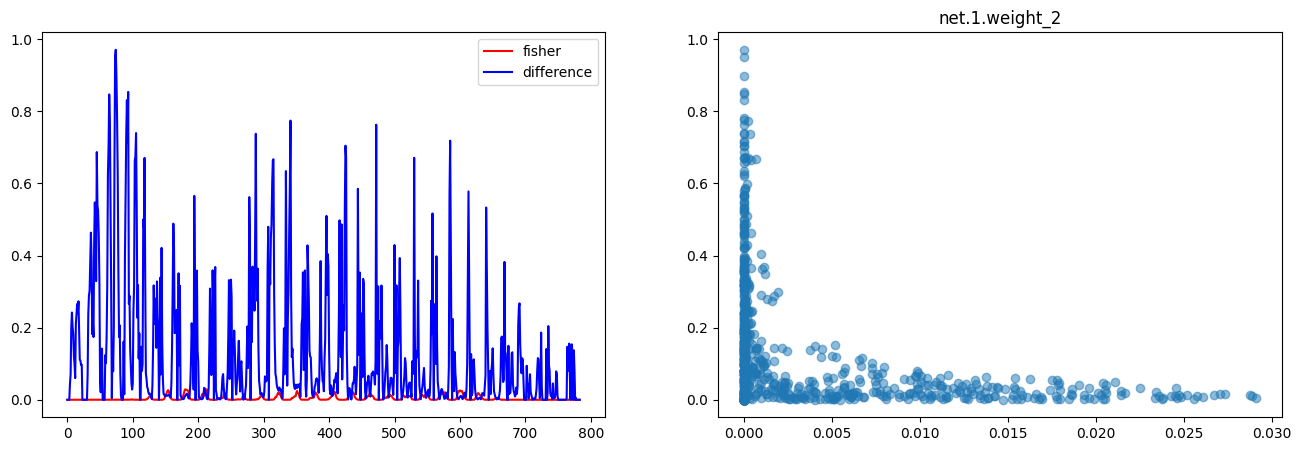

Max fisher is 0.11235 and it's parameter diff is 0.00205
Min Parameter diff is 0.99807 and it's fisher is 0.00001


<Figure size 640x480 with 0 Axes>

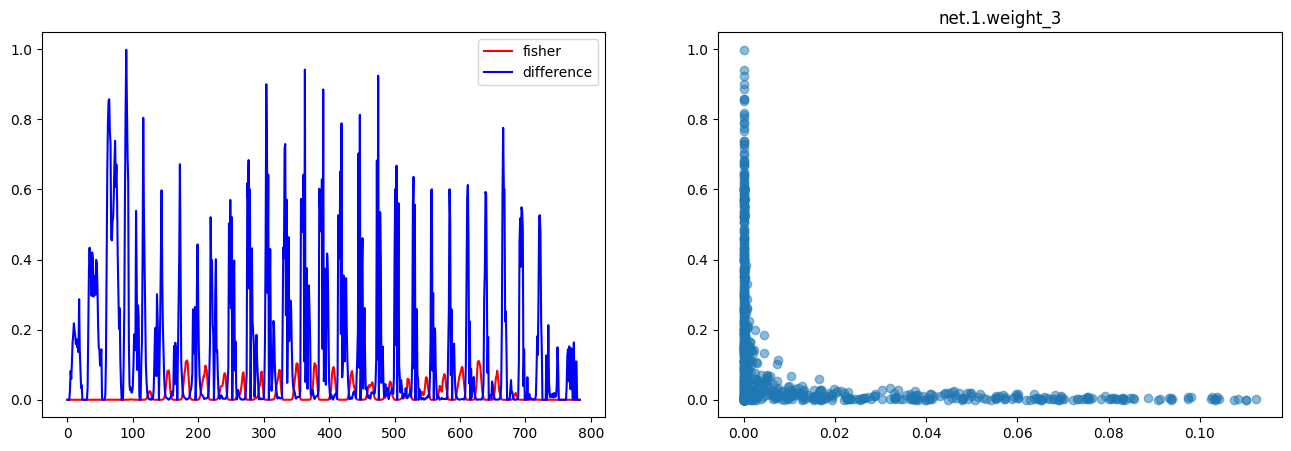

Max fisher is 0.00981 and it's parameter diff is 0.00156
Min Parameter diff is 1.06237 and it's fisher is 0.00000


<Figure size 640x480 with 0 Axes>

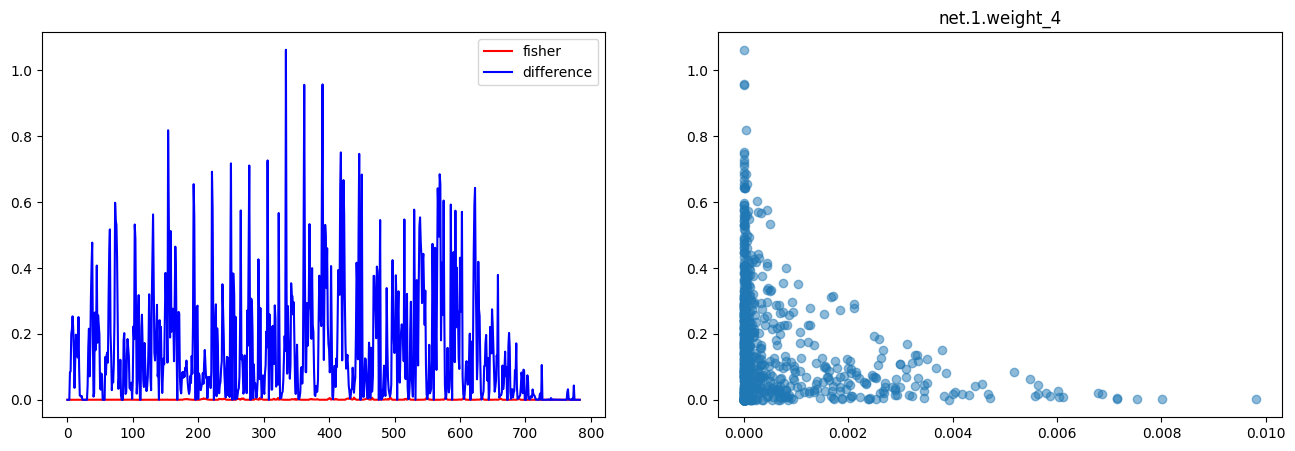

Max fisher is 0.17067 and it's parameter diff is 0.00344
Min Parameter diff is 1.31882 and it's fisher is 0.00010


<Figure size 640x480 with 0 Axes>

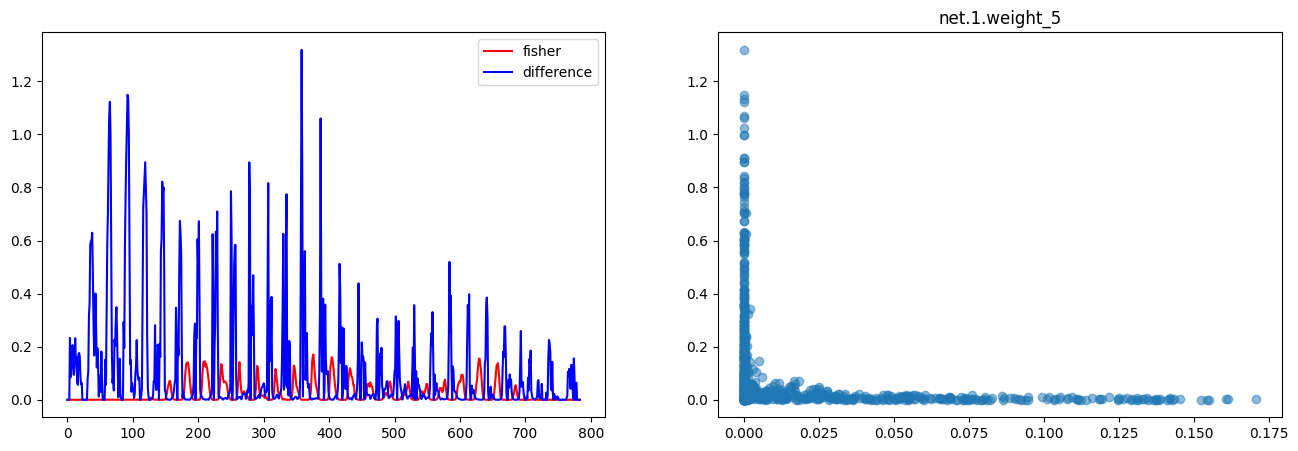

Max fisher is 0.01438 and it's parameter diff is 0.00130
Min Parameter diff is 0.82165 and it's fisher is 0.00000


<Figure size 640x480 with 0 Axes>

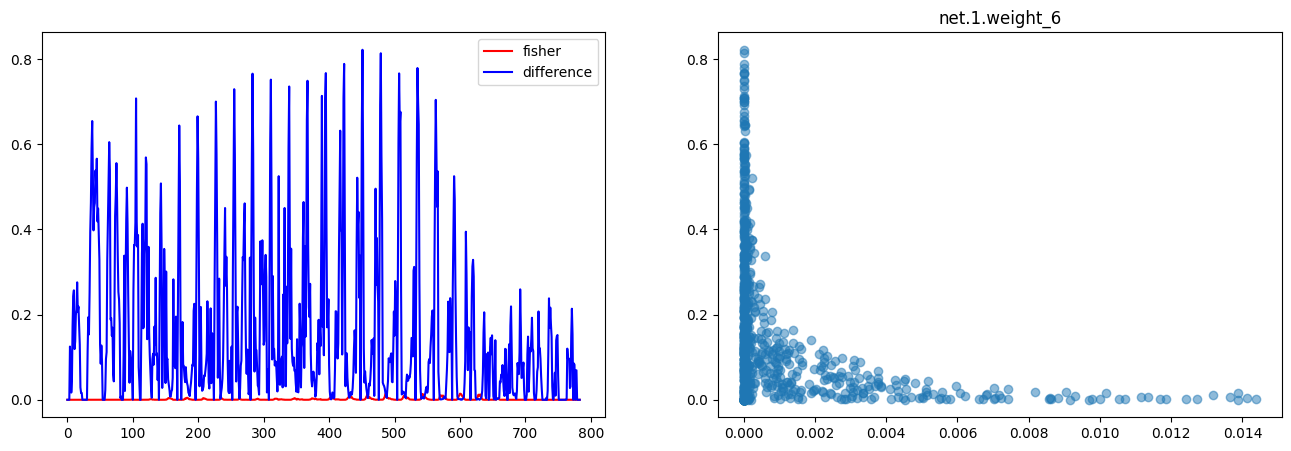

Max fisher is 0.05117 and it's parameter diff is 0.00931
Min Parameter diff is 1.02788 and it's fisher is 0.00000


<Figure size 640x480 with 0 Axes>

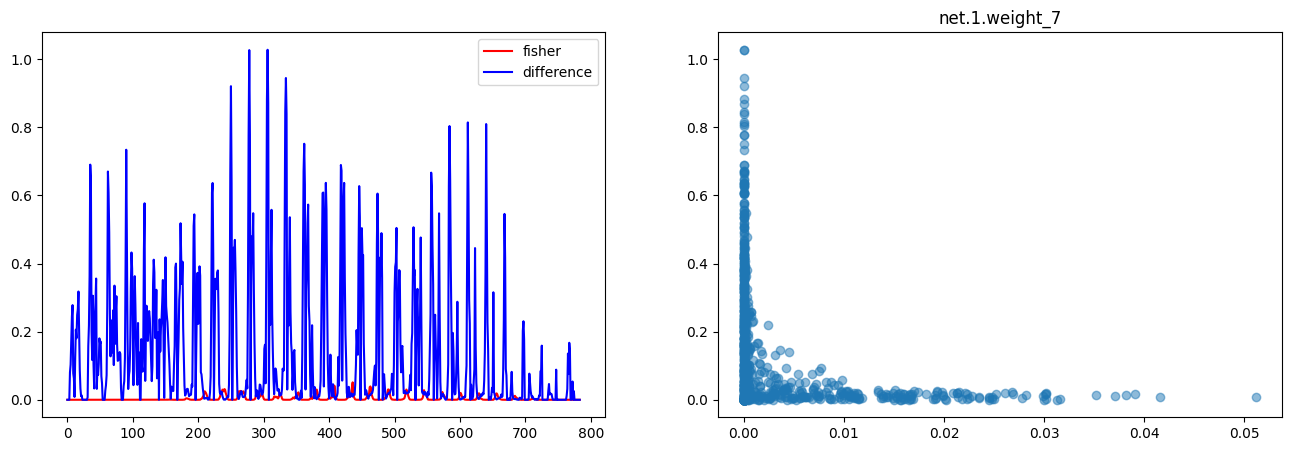

Max fisher is 0.58544 and it's parameter diff is 0.00034
Min Parameter diff is 1.09408 and it's fisher is 0.00001


<Figure size 640x480 with 0 Axes>

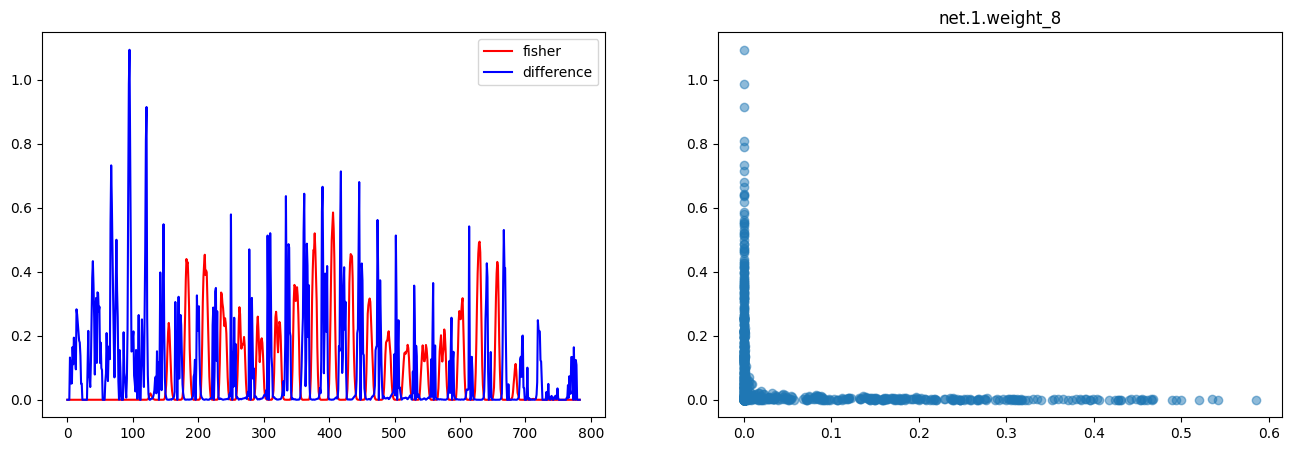

Max fisher is 0.10809 and it's parameter diff is 0.00392
Min Parameter diff is 1.26917 and it's fisher is 0.00002


<Figure size 640x480 with 0 Axes>

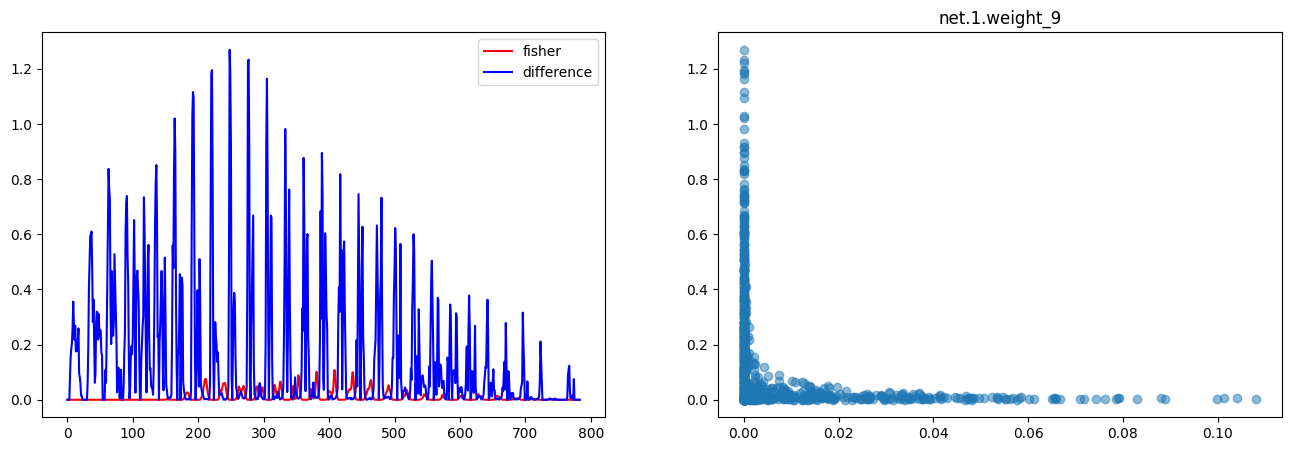


net.1.bias
torch.Size([10])
Max fisher is 1.98047 and it's parameter diff is 0.00031
Min Parameter diff is 0.02556 and it's fisher is 0.00298


<Figure size 640x480 with 0 Axes>

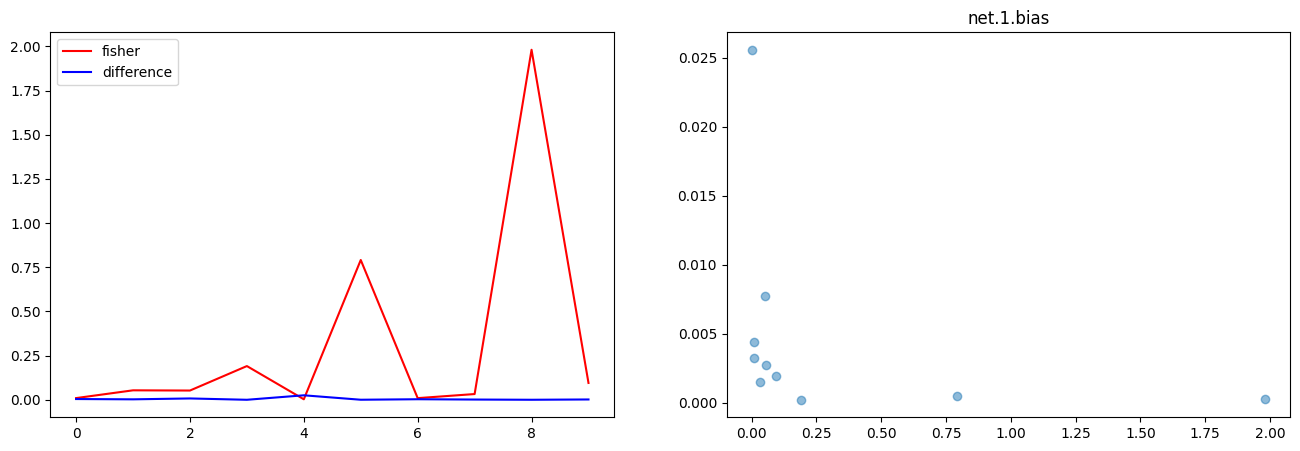

In [48]:
def plot(fisher_matrix, optim_para, param, name):
  plt.cla(); plt.clf()
  #print(fisher_matrix.shape, optim_para.shape, param.shape)
  fisher = fisher_matrix.cpu().detach()
  optim = optim_para.cpu().detach()
  param = param.cpu().detach()

  fisher_max = np.argmax(fisher)
  param_diff_max = np.argmax((optim - param).abs())
  print(f'Max fisher is {fisher[fisher_max]:.5f} and it\'s parameter diff is {(optim - param).abs()[fisher_max]:.5f}')
  print(f'Min Parameter diff is {(optim - param).abs()[param_diff_max]:.5f} and it\'s fisher is {fisher[param_diff_max]:.5f}')

  fig, ax = plt.subplots(1, 2, figsize=(16, 5)) # row, col
  ax[0].plot(fisher.reshape(-1), 'r', label='fisher')
  ax[0].plot((optim - param).abs().reshape(-1), 'b', label='difference')
  ax[0].legend()

  ax[1].scatter(fisher, (optim - param).abs().reshape(-1), alpha=0.5)
  plt.title(name)
  plt.show()

# test
idx = 0
for name, param in model.named_parameters():

  # Name
  print(name)
  print(param.detach().shape)

  if len(param.detach().shape) != 1:
    for i in range(param.detach().shape[0]):
      plot(fisher_matrix[0][name][i], optim_para[0][name][i], param[i], f'{name}_{i}')
  else:
    plot(fisher_matrix[0][name], optim_para[0][name], param, name)
  # END
  idx += 1
  print()

In [45]:
import datetime
import pytz

now = datetime.datetime.now(pytz.timezone('Asia/Taipei')).strftime("%Y-%m-%d_%H_%M_%S")
print(now)

2025-03-23_20_15_26
